# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Описание проекта**

Данные находятся в трёх файлах:\
gold_recovery_train_new.csv — обучающая выборка;\
gold_recovery_test_new.csv — тестовая выборка;\
gold_recovery_full_new.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

**ОПИСАНИЕ ДАННЫХ**

**Технологический процесс**

Rougher feed — исходное сырье\
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).

Rougher process (англ. «грубый процесс») — флотация\
Rougher tails — отвальные хвосты\
Float banks — флотационная установка\
Cleaner process — очистка\
Rougher Au — черновой концентрат золота\
Final Au — финальный концентрат золота

**Параметры этапов**

air amount — объём воздуха\
fluid levels — уровень жидкости\
feed size — размер гранул сырья\
feed rate — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:\
[этап].[тип_параметра].[название_параметра]\
Пример: *rougher.input.feed_ag*

Возможные значения для блока [этап]:\
rougher — флотация\
primary_cleaner — первичная очистка\
secondary_cleaner — вторичная очистка\
final — финальные характеристики

Возможные значения для блока [тип_параметра]:\
input — параметры сырья\
output — параметры продукта\
state — параметры, характеризующие текущее состояние этапа\
calculation — расчётные характеристики

## Подготовка данных

### Открытие и изучение файлов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [2]:
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [3]:
# сброс ограничений на количество выводимых строк
pd.options.display.max_rows=999

Создадим список из трёх выборок данных и изчим общую информацию о данных, содержание таблиц, количество дубликатов и пропусков.

In [4]:
data_list = [data_full, data_train, data_test]

In [5]:
for data in data_list:
    print(colored('Общая информация:', 'red'))
    data.info()
    display(data.head(3), data.tail(3))
    display(data.describe())
    print(colored('Количество дубликатов:', 'red'), data.duplicated().sum())
    print(colored('Количество отсутствующих значений:', 'red'))
    display(data.isna().sum())

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
19436,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
19437,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
19438,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Количество дубликатов: 0
Количество отсутствующих значений:


date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 3

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
14148,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Количество дубликатов: 0
Количество отсутствующих значений:


date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           20
primary_cleaner.input.depressant                        32
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         100
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 2

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5287,2017-12-31 21:59:59,171.135718,15.993669,8.07,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284
5289,2017-12-31 23:59:59,181.556856,14.995850,8.07,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,20.034715,-500.728588,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Количество дубликатов: 0
Количество отсутствующих значений:


date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

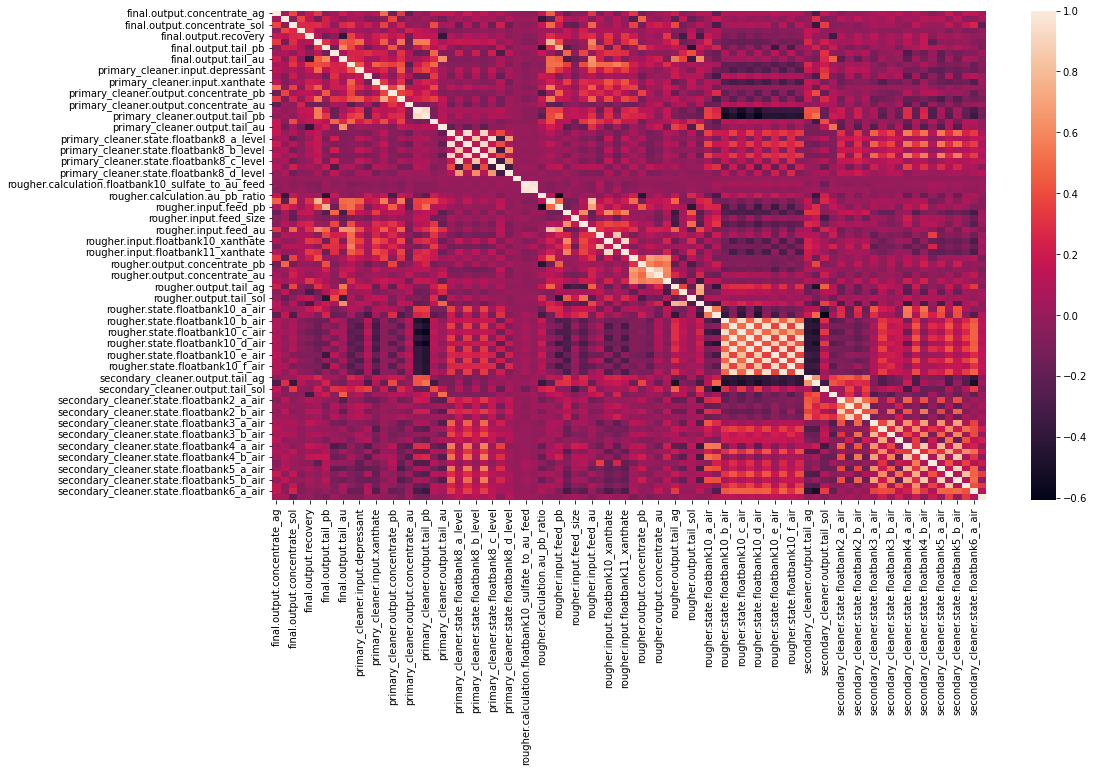

In [6]:
plt.figure(figsize = (16,9))
sns.heatmap(data_full.corr());

**Вывод**

Данные исходных таблиц имеют вещественный формат, кроме строковых столбцов date, которые следует привести к временному формату, и расположены в хронологическом порядке с интервалом в 1 час.
В данных отсутствуют дубликаты, однако, имеются пропуски, которые нужно обработать.

На хитмэпе можно обнаружить сильные корреляции между некоторыми признаками.

### Проверка, что эффективность обогащения рассчитана правильно. Вычисление её на обучающей выборке для признака rougher.output.recovery. Вычисление MAE между расчётами и значением признака. Выводы

Эффективность обогащения рассчитывается по формуле:

recovery = (C*(F-T)) / (F*(C-T)) * 100%

где:\
C — доля золота в концентрате после флотации/очистки;\
F — доля золота в сырье/концентрате до флотации/очистки;\
T — доля золота в отвальных хвостах после флотации/очистки.

In [7]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

In [8]:
# эффективность ообогащения
recovery = (C * (F - T)) / (F * (C - T)) * 100

print(f'Средняя эффектиность обогащения: {recovery.mean()}')
print(f"MAE: {mean_absolute_error(recovery, data_train['rougher.output.recovery'])}")

Средняя эффектиность обогащения: 82.70450164550269
MAE: 9.73512347450521e-15


Значение ошибки MAE очень мало. Расчёт произведён верно.

### Анализ признаков, недоступных в тестовой выборке. Что это за параметры? К какому типу относятся?

In [9]:
# отсутствующие в тестовой выборке столбцы
missing_columns = set(data_train.columns) - set(data_test.columns)
missing_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Отсутствующие в тестовой выборке столбцы представляют собой данные промежуточных этапов извлечения металлов из руды а также некоторые расчетные соотношения содержания металлов и реагентов.

### Предобработка данных

In [10]:
# перевод значений столбцов date таблице в формат datetime
for data in data_list:
    data['date'] = pd.to_datetime(data['date'])

Заполним пропущенные значения таблиц методом интерполяции.

In [11]:
for data in data_list:
    for col in data.columns:
        if col != 'date':
            data[col] = data[col].interpolate()

In [12]:
# data_full.isna().sum()
# data_train.isna().sum()
# data_test.isna().sum()

**Вывод:**

Данные обработаны и готовы к анализу.

## Анализ данных

### Изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Выводы

In [13]:
# data_full.info()

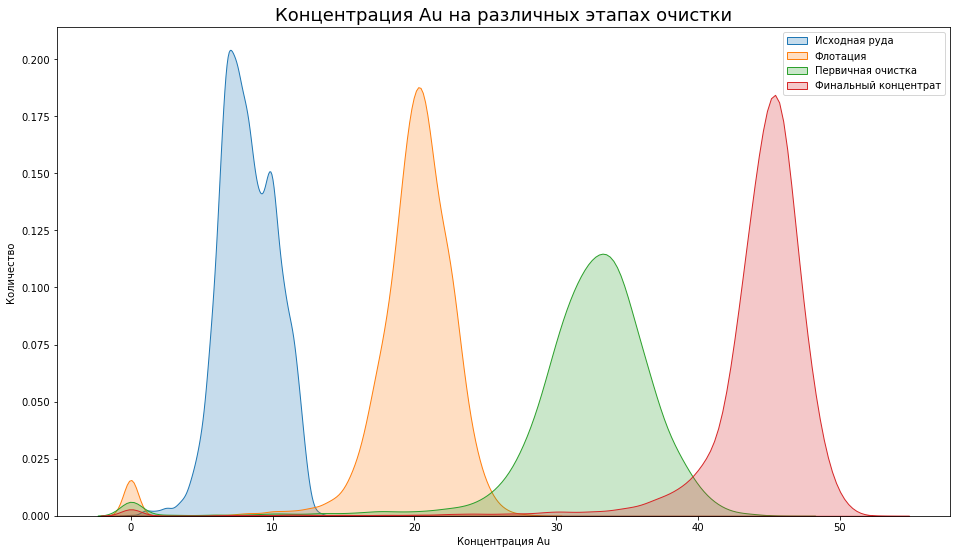

In [14]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=data_full['rougher.input.feed_au'], fill=True, label='Исходная руда')
sns.kdeplot(data=data_full['rougher.output.concentrate_au'], fill=True, label='Флотация')
sns.kdeplot(data=data_full['primary_cleaner.output.concentrate_au'], fill=True, label='Первичная очистка')
sns.kdeplot(data=data_full['final.output.concentrate_au'], fill=True, label='Финальный концентрат')

plt.title('Концентрация Au на различных этапах очистки', fontsize=18)
plt.legend()
plt.xlabel('Концентрация Au')
plt.ylabel('Количество ');

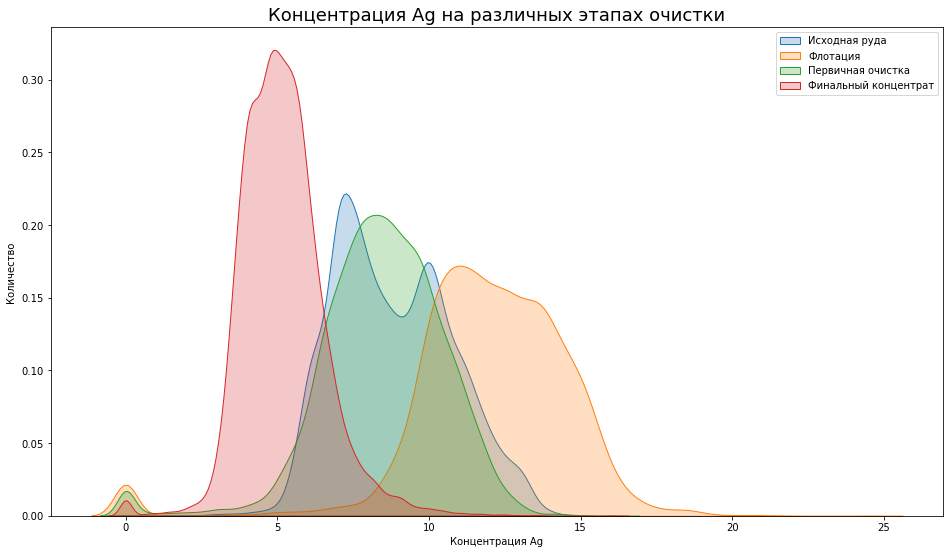

In [15]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=data_full['rougher.input.feed_ag'], fill=True, label='Исходная руда')
sns.kdeplot(data=data_full['rougher.output.concentrate_ag'], fill=True, label='Флотация')
sns.kdeplot(data=data_full['primary_cleaner.output.concentrate_ag'], fill=True, label='Первичная очистка')
sns.kdeplot(data=data_full['final.output.concentrate_ag'], fill=True, label='Финальный концентрат')

plt.title('Концентрация Ag на различных этапах очистки', fontsize=18)
plt.legend()
plt.xlabel('Концентрация Ag')
plt.ylabel('Количество ');

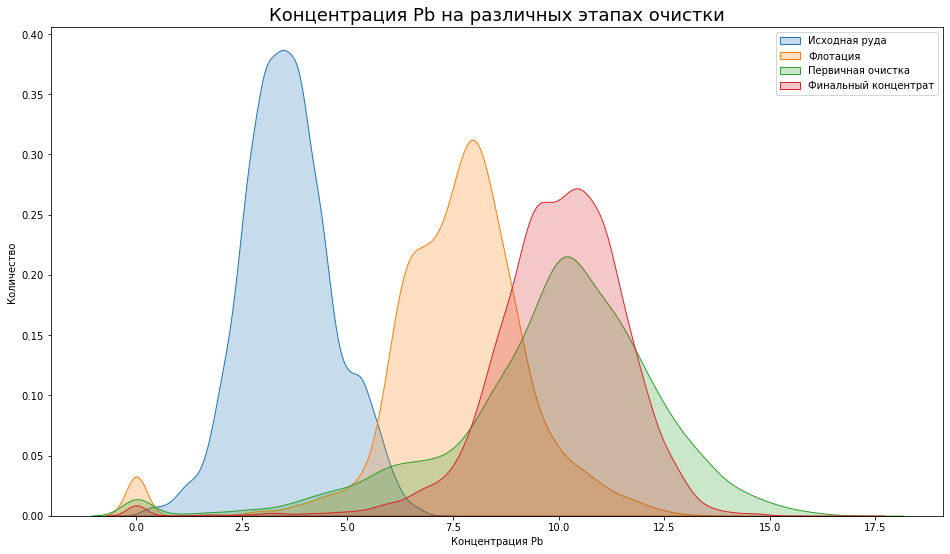

In [16]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=data_full['rougher.input.feed_pb'], fill=True, label='Исходная руда')
sns.kdeplot(data=data_full['rougher.output.concentrate_pb'], fill=True, label='Флотация')
sns.kdeplot(data=data_full['primary_cleaner.output.concentrate_pb'], fill=True, label='Первичная очистка')
sns.kdeplot(data=data_full['final.output.concentrate_pb'], fill=True, label='Финальный концентрат')

plt.title('Концентрация Pb на различных этапах очистки', fontsize=18)
plt.legend()
plt.xlabel('Концентрация Pb')
plt.ylabel('Количество');

**Выводы:**
* На каждом этапе очистки концентрация золота увеличивается
* Концентрация серебра на этапе флотации увеличивается, затем снижается
* Концентрация свинца увеличивается с каждым этапом очистки

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

In [17]:
# data_train.info()
# data_test.info()

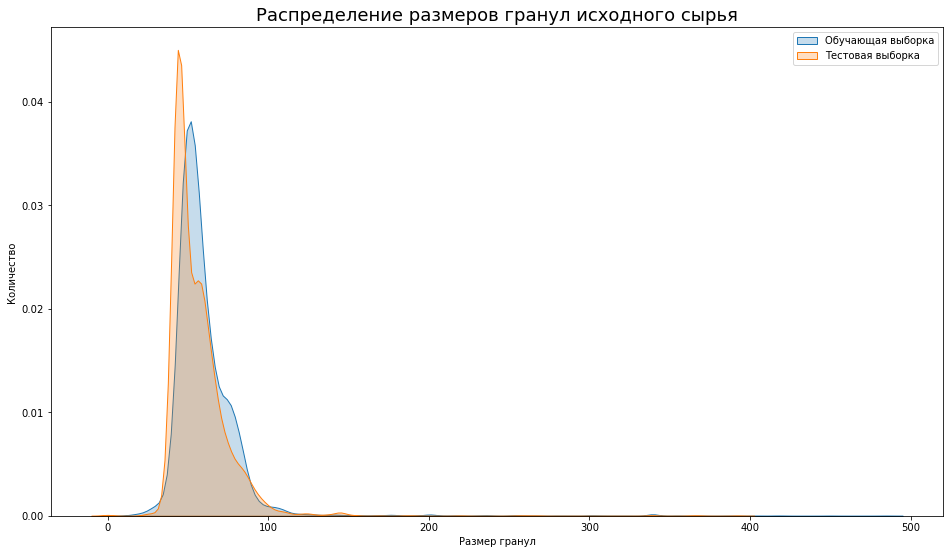

In [18]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=data_train['rougher.input.feed_size'], fill=True, label='Обучающая выборка')
sns.kdeplot(data=data_test['rougher.input.feed_size'], fill=True, label='Тестовая выборка')

plt.title('Распределение размеров гранул исходного сырья', fontsize=18)
plt.legend()
plt.xlabel('Размер гранул')
plt.ylabel('Количество');

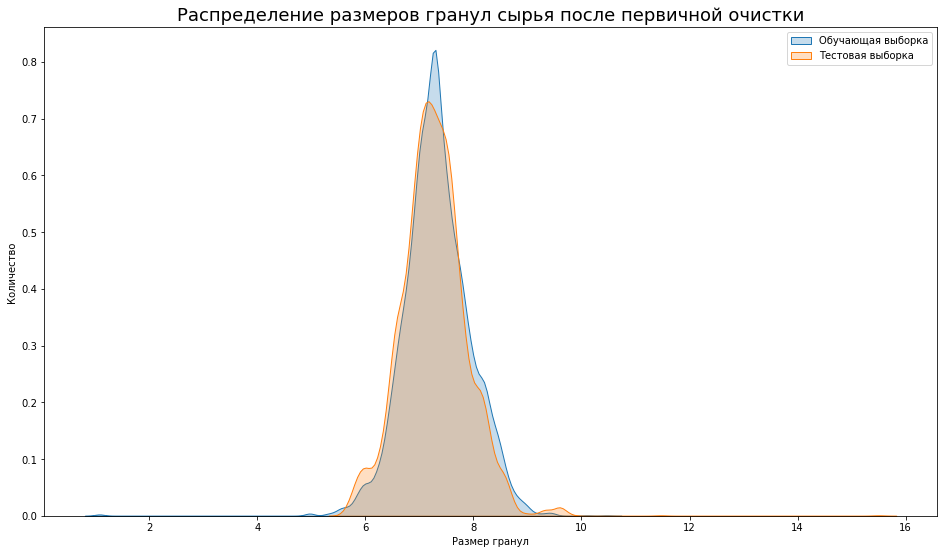

In [19]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=data_train['primary_cleaner.input.feed_size'], fill=True, label='Обучающая выборка')
sns.kdeplot(data=data_test['primary_cleaner.input.feed_size'], fill=True, label='Тестовая выборка')

plt.title('Распределение размеров гранул сырья после первичной очистки', fontsize=18)
plt.legend()
plt.xlabel('Размер гранул')
plt.ylabel('Количество');

**Вывод:**
Распределения гранул сырья практически не отличаются. Данные можно использовать для построения модели.

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [20]:
def sum_concentrate(data, Au, Ag, Pb, Sol):
    """
    функция суммирует значения веществ по столбцам
    data - датафрейм
    Au, Ag, Pb, Sol - столбцы со значениями соответствующих веществ
    """
    sum_col = data[[Au, Ag, Pb, Sol]].sum(axis=1)
    return sum_col

In [21]:
# концентрация веществ в исходном сырье
rougher_input_sum = sum_concentrate(
    data_full, 'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol')
# концентрация веществ после флотации
rougher_output_sum = sum_concentrate(
    data_full, 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol')
# концентрация веществ после первичной очистки
primary_cleaner_output_sum = sum_concentrate(
    data_full, 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol')
# после финальной концентрации
final_output_concentrate_sum = sum_concentrate(
    data_full, 'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol')

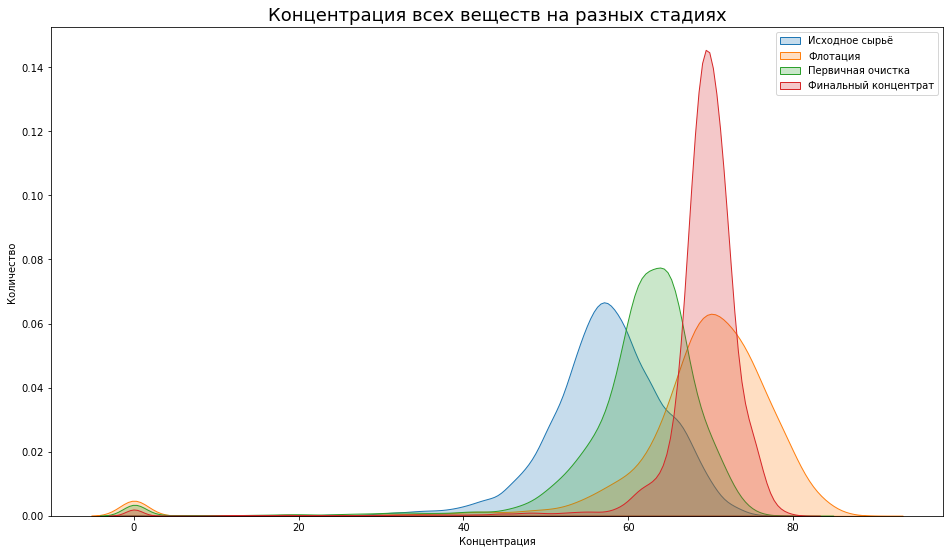

In [22]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=rougher_input_sum, fill=True, label='Исходное сырьё')
sns.kdeplot(data=rougher_output_sum, fill=True, label='Флотация')
sns.kdeplot(data=primary_cleaner_output_sum, fill=True, label='Первичная очистка')
sns.kdeplot(data=final_output_concentrate_sum, fill=True, label='Финальный концентрат')

plt.title('Концентрация всех веществ на разных стадиях', fontsize=18)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Количество');

На графиках обнаруживаются аномальные значения концентрации веществ равные 0. Избавимся от этих выбросов.

In [23]:
def filter_zero(data):
    """Функция для удаления суммарных нулевых концентраций веществ"""
    data['concentrate_sum_1'] = data[['rougher.input.feed_au',
                                      'rougher.input.feed_ag',
                                      'rougher.input.feed_pb',
                                      'rougher.input.feed_sol']].sum(axis=1)
    data['concentrate_sum_2'] = data[['rougher.output.concentrate_au',
                                      'rougher.output.concentrate_ag',
                                      'rougher.output.concentrate_pb',
                                      'rougher.output.concentrate_sol']].sum(axis=1)
    data['concentrate_sum_3'] = data[['primary_cleaner.output.concentrate_au',
                                      'primary_cleaner.output.concentrate_ag',
                                      'primary_cleaner.output.concentrate_pb',
                                      'primary_cleaner.output.concentrate_sol']].sum(axis=1)
    data['concentrate_sum_4'] = data[['final.output.concentrate_au',
                                      'final.output.concentrate_ag',
                                      'final.output.concentrate_pb',
                                      'final.output.concentrate_sol']].sum(axis=1)
    data = data.query('(concentrate_sum_1 > 1) and (concentrate_sum_2 > 1) and (concentrate_sum_3 > 1) and (concentrate_sum_4 > 1)')
    return data

In [24]:
# создадим новый датафрейм на основе тестовой выборки,отсутствующие столбцы с данными которого наполним данными основного датафрейма
data_test_full = data_test.merge(data_full[['date','final.output.concentrate_ag',
                                       'final.output.concentrate_au',
                                       'final.output.concentrate_pb',
                                       'final.output.concentrate_sol',
                                       'final.output.recovery',
                                       'final.output.tail_ag',
                                       'final.output.tail_au',
                                       'final.output.tail_pb',
                                       'final.output.tail_sol',
                                       'primary_cleaner.output.concentrate_ag',
                                       'primary_cleaner.output.concentrate_au',
                                       'primary_cleaner.output.concentrate_pb',
                                       'primary_cleaner.output.concentrate_sol',
                                       'primary_cleaner.output.tail_ag','primary_cleaner.output.tail_au',
                                       'primary_cleaner.output.tail_pb',
                                       'primary_cleaner.output.tail_sol',
                                       'rougher.calculation.au_pb_ratio',
                                       'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                       'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                       'rougher.calculation.sulfate_to_au_concentrate',
                                       'rougher.output.concentrate_ag',
                                       'rougher.output.concentrate_au',
                                       'rougher.output.concentrate_pb',
                                       'rougher.output.concentrate_sol',
                                       'rougher.output.recovery',
                                       'rougher.output.tail_ag',
                                       'rougher.output.tail_au',
                                       'rougher.output.tail_pb',
                                       'rougher.output.tail_sol',
                                       'secondary_cleaner.output.tail_ag',
                                       'secondary_cleaner.output.tail_au',
                                       'secondary_cleaner.output.tail_pb',
                                       'secondary_cleaner.output.tail_sol']], how='inner', on=['date'])

In [25]:
data_full = filter_zero(data_full)
data_train = filter_zero(data_train)
data_test_full = filter_zero(data_test_full)

In [26]:
data_test = data_test_full.drop(['final.output.concentrate_ag',
                            'final.output.concentrate_au',
                            'final.output.concentrate_pb',
                            'final.output.concentrate_sol',
#                             'final.output.recovery',
                            'final.output.tail_ag',
                            'final.output.tail_au',
                            'final.output.tail_pb',
                            'final.output.tail_sol',
                            'primary_cleaner.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_au',
                            'primary_cleaner.output.concentrate_pb',
                            'primary_cleaner.output.concentrate_sol',
                            'primary_cleaner.output.tail_ag','primary_cleaner.output.tail_au',
                            'primary_cleaner.output.tail_pb',
                            'primary_cleaner.output.tail_sol',
                            'rougher.calculation.au_pb_ratio',
                            'rougher.calculation.floatbank10_sulfate_to_au_feed',
                            'rougher.calculation.floatbank11_sulfate_to_au_feed',
                            'rougher.calculation.sulfate_to_au_concentrate',
                            'rougher.output.concentrate_ag',
                            'rougher.output.concentrate_au',
                            'rougher.output.concentrate_pb',
                            'rougher.output.concentrate_sol',
#                             'rougher.output.recovery',
                            'rougher.output.tail_ag',
                            'rougher.output.tail_au',
                            'rougher.output.tail_pb',
                            'rougher.output.tail_sol',
                            'secondary_cleaner.output.tail_ag',
                            'secondary_cleaner.output.tail_au',
                            'secondary_cleaner.output.tail_pb',
                            'secondary_cleaner.output.tail_sol'], axis=1)

Построим графики распределения веществ для отфильтрованного датафрейма

In [27]:
# концентрация веществ в исходном сырье
rougher_input_sum = sum_concentrate(
    data_full, 'rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol')
# концентрация веществ после флотации
rougher_output_sum = sum_concentrate(
    data_full, 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol')
# концентрация веществ после первичной очистки
primary_cleaner_output_sum = sum_concentrate(
    data_full, 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol')
# после финальной концентрации
final_output_concentrate_sum = sum_concentrate(
    data_full, 'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol')

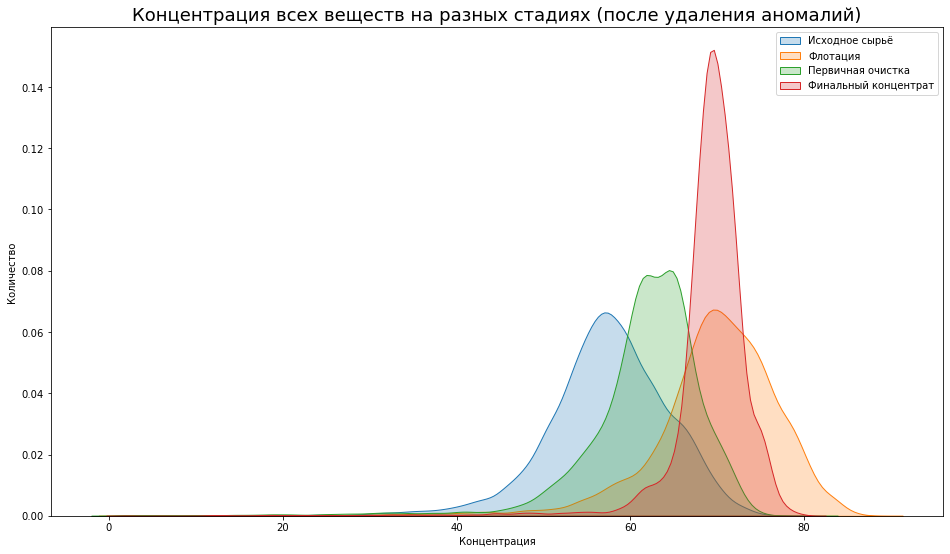

In [28]:
plt.figure(figsize = (16,9))

sns.kdeplot(data=rougher_input_sum, fill=True, label='Исходное сырьё')
sns.kdeplot(data=rougher_output_sum, fill=True, label='Флотация')
sns.kdeplot(data=primary_cleaner_output_sum, fill=True, label='Первичная очистка')
sns.kdeplot(data=final_output_concentrate_sum, fill=True, label='Финальный концентрат')

plt.title('Концентрация всех веществ на разных стадиях (после удаления аномалий)', fontsize=18)
plt.legend()
plt.xlabel('Концентрация')
plt.ylabel('Количество');

По мере прохождения стадий очистки от исходного сырья к черновому и финальному концентрату возрастает количество и концентрация металлов, главным образом золота.

## Модель

### Функция для вычисления итоговой sMAPE

Метрика качества

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).\
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.\
Метрика sMAPE вычисляется так:

<img src="https://pictures.s3.yandex.net/resources/smape_1576239058.jpg">

Обозначения:

 <img src="https://pictures.s3.yandex.net/resources/y1_1576238832.jpg">
•	Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.
 <img src="https://pictures.s3.yandex.net/resources/yi_1_1576238835.jpg">
•	Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.
 <img src="https://pictures.s3.yandex.net/resources/N_1_1576238819.jpg">
•	Количество объектов в выборке.
 <img src="https://pictures.s3.yandex.net/resources/I_1576238817.jpg">
•	Суммирование по всем объектам выборки (i меняется от 1 до N).


Нужно спрогнозировать сразу две величины:
1.	эффективность обогащения чернового концентрата rougher.output.recovery;
2.	эффективность обогащения финального концентрата final.output.recovery.
Итоговая метрика складывается из двух величин:
 
 <img src="https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg">

In [29]:
def smape(target, predictions):
    """Функция для определения sMAPE"""
    smape = 1/len(target) * np.sum(2 * np.abs(target - predictions) / (np.abs(target)  + np.abs(predictions)) * 100)
    return smape

In [30]:
def final_smape(target, predictions):
    """Функция для определения итогового sMAPE"""
    smape_rougher = smape(target['rougher.output.recovery'], predictions[:,0])
    smape_final = smape(target['final.output.recovery'], predictions[:,1])
    final_smape = (0.25 * smape_rougher) + (0.75 * smape_final)
    return final_smape

### Обучение разные моделей и оценка их качества кросс-валидацией. Выбор лучшей модели и проверка её на тестовой выборке. Выводы

In [31]:
# разделение тестовой выборки на признаки и целевое значение
features_train = data_train.drop(['date','final.output.concentrate_ag',
                                     'final.output.concentrate_au',
                                     'final.output.concentrate_pb',
                                     'final.output.concentrate_sol',
                                     'final.output.recovery',
                                     'final.output.tail_ag',
                                     'final.output.tail_au',
                                     'final.output.tail_pb',
                                     'final.output.tail_sol',
                                     'primary_cleaner.output.concentrate_ag',
                                     'primary_cleaner.output.concentrate_au',
                                     'primary_cleaner.output.concentrate_pb',
                                     'primary_cleaner.output.concentrate_sol',
                                     'primary_cleaner.output.tail_ag',
                                     'primary_cleaner.output.tail_au',
                                     'primary_cleaner.output.tail_pb',
                                     'primary_cleaner.output.tail_sol',
                                     'rougher.calculation.au_pb_ratio',
                                     'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                     'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                     'rougher.calculation.sulfate_to_au_concentrate',
                                     'rougher.output.concentrate_ag',
                                     'rougher.output.concentrate_au',
                                     'rougher.output.concentrate_pb',
                                     'rougher.output.concentrate_sol',
                                     'rougher.output.recovery',
                                     'rougher.output.tail_ag',
                                     'rougher.output.tail_au',
                                     'rougher.output.tail_pb',
                                     'rougher.output.tail_sol',
                                     'secondary_cleaner.output.tail_ag',
                                     'secondary_cleaner.output.tail_au',
                                     'secondary_cleaner.output.tail_pb',
                                     'secondary_cleaner.output.tail_sol',
                                     'concentrate_sum_1', 'concentrate_sum_2',
                                     'concentrate_sum_3', 'concentrate_sum_4'], axis=1)
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]

In [32]:
display(features_train.shape)
target_train.shape

(13599, 52)

(13599, 2)

In [33]:
# разделение тестовой выборки на признаки и целевое значение
features_test = data_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery', 'concentrate_sum_1', 'concentrate_sum_2', 'concentrate_sum_3', 'concentrate_sum_4'], axis=1)
target_test = data_test[['rougher.output.recovery', 'final.output.recovery']]

In [34]:
display(features_test.shape)
target_test.shape

(5123, 52)

(5123, 2)

In [35]:
# создание метрики sMAPE
smape_score = make_scorer(final_smape, greater_is_better=False)

In [36]:
def fast_model(model_name, features, target, model_name_text):
    """Функция для подсчёта эффективности модели на стандартных гиперпараметрах"""
    model = model_name
    model.fit(features, target)
    score = cross_val_score(model, features, target, scoring=smape_score).mean()
    print(f'Результат модели {model_name_text}: {score}')
    return score

In [37]:
# тест для дерева решений
decision_tree_score = fast_model(DecisionTreeRegressor(random_state=12345), features_train, target_train, 'Дерево решений')

Результат модели Дерево решений: -14.924045976836098


In [38]:
# тест для случайного леса
random_forest_score = fast_model(RandomForestRegressor(random_state=12345), features_train, target_train, 'Случайный лес')

Результат модели Случайный лес: -9.130338063052358


In [39]:
# тест для линейной регрессии
linear_score = fast_model(LinearRegression(), features_train, target_train, 'Линейная регрессия')

Результат модели Линейная регрессия: -10.069419150750795


Лучший показатель sMAPE модели со стандартными гиперпараметрами у случайного леса.

In [40]:
# разобьём наборы целевых признаков
target_train_rougher = target_train['rougher.output.recovery']
target_train_final = target_train['final.output.recovery']
target_test_rougher = target_test['rougher.output.recovery']
target_test_final = target_test['final.output.recovery']

In [41]:
forest_rougher = RandomForestRegressor(random_state=12345)
forest_rougher.fit(features_train, target_train_rougher)
predict_forest_rougher = forest_rougher.predict(features_train)
score_forest_rougher = smape(target_train_rougher, predict_forest_rougher)
print('Результат модели Случайный лес для первого набора признаков', score_forest_rougher)

Результат модели Случайный лес для первого набора признаков 0.9340932120614917


In [42]:
forest_final = RandomForestRegressor(random_state=12345)
forest_final.fit(features_train, target_train_final)
predict_forest_final = forest_final.predict(features_train)
score_forest_final = smape(target_train_final, predict_forest_final)
print('Результат модели Случайный лес для второго набора признаков', score_forest_final)

Результат модели Случайный лес для второго набора признаков 2.1540726942898414


In [43]:
final_smape_forest = 0.25 * score_forest_rougher + 0.75 * score_forest_final
print('Результат модели Случайный лес', final_smape_forest)

Результат модели Случайный лес 1.849077823732754


In [44]:
cat_rougher = CatBoostRegressor()
cat_rougher.fit(features_train, target_train_rougher)
predict_cat_rougher = cat_rougher.predict(features_train)
score_cat_rougher = smape(target_train_rougher, predict_cat_rougher)
print('Результат модели CatBoost для первого набора признаков', score_cat_rougher)

Learning rate set to 0.061841
0:	learn: 7.6849081	total: 91.3ms	remaining: 1m 31s
1:	learn: 7.4528040	total: 109ms	remaining: 54.4s
2:	learn: 7.2546210	total: 126ms	remaining: 41.9s
3:	learn: 7.0578598	total: 143ms	remaining: 35.7s
4:	learn: 6.8882052	total: 160ms	remaining: 31.9s
5:	learn: 6.7297042	total: 182ms	remaining: 30.2s
6:	learn: 6.5909964	total: 200ms	remaining: 28.4s
7:	learn: 6.4533522	total: 217ms	remaining: 26.9s
8:	learn: 6.3167983	total: 234ms	remaining: 25.7s
9:	learn: 6.1999365	total: 250ms	remaining: 24.8s
10:	learn: 6.0889341	total: 270ms	remaining: 24.3s
11:	learn: 5.9898218	total: 291ms	remaining: 23.9s
12:	learn: 5.8971043	total: 312ms	remaining: 23.7s
13:	learn: 5.8108717	total: 333ms	remaining: 23.4s
14:	learn: 5.7202702	total: 349ms	remaining: 22.9s
15:	learn: 5.6375335	total: 367ms	remaining: 22.5s
16:	learn: 5.5631569	total: 389ms	remaining: 22.5s
17:	learn: 5.4918434	total: 410ms	remaining: 22.4s
18:	learn: 5.4292200	total: 426ms	remaining: 22s
19:	learn: 

In [45]:
cat_final = CatBoostRegressor()
cat_final.fit(features_train, target_train_final)
predict_cat_final = cat_final.predict(features_train)
score_cat_final = smape(target_train_final, predict_cat_final)
print('Результат модели CatBoost для второго набора признаков', score_cat_final)

Learning rate set to 0.061841
0:	learn: 8.9712672	total: 34.4ms	remaining: 34.4s
1:	learn: 8.8149136	total: 54.7ms	remaining: 27.3s
2:	learn: 8.6668213	total: 75.1ms	remaining: 25s
3:	learn: 8.5310512	total: 93.8ms	remaining: 23.3s
4:	learn: 8.3953493	total: 110ms	remaining: 21.9s
5:	learn: 8.2753925	total: 134ms	remaining: 22.1s
6:	learn: 8.1572144	total: 154ms	remaining: 21.9s
7:	learn: 8.0562203	total: 172ms	remaining: 21.3s
8:	learn: 7.9656701	total: 189ms	remaining: 20.8s
9:	learn: 7.8800262	total: 212ms	remaining: 21s
10:	learn: 7.8006734	total: 231ms	remaining: 20.8s
11:	learn: 7.7255133	total: 248ms	remaining: 20.4s
12:	learn: 7.6574572	total: 265ms	remaining: 20.1s
13:	learn: 7.5917794	total: 281ms	remaining: 19.8s
14:	learn: 7.5308949	total: 297ms	remaining: 19.5s
15:	learn: 7.4708867	total: 314ms	remaining: 19.3s
16:	learn: 7.4177172	total: 331ms	remaining: 19.2s
17:	learn: 7.3641138	total: 354ms	remaining: 19.3s
18:	learn: 7.3182529	total: 372ms	remaining: 19.2s
19:	learn: 

In [46]:
final_smape_cat = 0.25 * score_cat_rougher + 0.75 * score_cat_final
print('Результат модели CatBoost', final_smape_cat)

Результат модели CatBoost 3.3941330178192155


**Проверка модели CatBoost на тестовой выборке**

In [47]:
predict_cat_rougher_test = cat_rougher.predict(features_test)
score_cat_rougher_test = smape(target_test_rougher, predict_cat_rougher_test)
print('Результат модели CatBoost для первого набора признаков на тестовой выборке', score_cat_rougher_test)

Результат модели CatBoost для первого набора признаков на тестовой выборке 4.077135262963122


In [48]:
predict_cat_final_test = cat_final.predict(features_test)
score_cat_final_test = smape(target_test_final, predict_cat_final_test)
print('Результат модели CatBoost для второго набора признаков на тестовой выборке', score_cat_final_test)

Результат модели CatBoost для второго набора признаков на тестовой выборке 8.428984145184819


In [49]:
final_smape_cat_test = 0.25 * score_cat_rougher_test + 0.75 * score_cat_final_test
print('Результат модели CatBoost на тестовой выборке', final_smape_cat_test)

Результат модели CatBoost на тестовой выборке 7.341021924629394


**Проверим модель случайного леса на тестовой выборке.**

In [50]:
predict_forest_rougher_test = forest_rougher.predict(features_test)
score_forest_rougher_test = smape(target_test_rougher, predict_forest_rougher_test)
print('Результат модели Случайный лес для первого набора признаков на тестовой выборке', score_forest_rougher_test)

Результат модели Случайный лес для первого набора признаков на тестовой выборке 4.25159431963771


In [51]:
predict_forest_final_test = forest_final.predict(features_test)
score_forest_final_test = smape(target_test_final, predict_forest_final_test)
print('Результат модели Случайный лес для второго набора признаков на тестовой выборке', score_forest_final_test)

Результат модели Случайный лес для второго набора признаков на тестовой выборке 8.310219556473761


In [52]:
final_smape_forest_test = 0.25 * score_forest_rougher_test + 0.75 * score_forest_final_test
print('Результат модели Случайный лес на тестовой выборке', final_smape_forest_test)

Результат модели Случайный лес на тестовой выборке 7.295563247264749


**Общий вывод:**

При рассмотрении данных на разных этапах обработки сырья было выявлено:
* На каждом этапе очистки концентрация золота увеличивается
* Концентрация серебра на этапе флотации увеличивается, затем снижается
* Концентрация свинца увеличивается с каждым этапом очистки

Для оценки качества работы моделей была введена метрика smape (symmetric mean absolute percentage error).

Лучшей моделью по итогам исследования оказалась модель **случайного леса**, которая на стандартных гиперпараметрах показывает вероятность ошибки 7.3%.